## Pytorch sur des séquences de texte

#### Import des librairies

In [1]:
import torchtext # pip install torchtext
import torch
import torch.nn as nn
import torch.optim as optim
#from torchtext.data import Field, TabularDataset, BucketIterator
from torchtext.legacy.data import Field, TabularDataset, BucketIterator

In [ ]:
# Commandes utiles en cas de lib manquantes :

# !pip3 install -U spacy                       # spaCy lib
# !pip3 install torch torchvision torchaudio   # PyTorch (see <pytorch.org/get-started/locally> for GPU support)
# !python -m spacy download en_core_web_trf    # download spaCy trained pipeline

In [2]:
import spacy
# TODO: find a way to merge EN & FR language pipelines
spacy_en = spacy.load('en_core_web_trf')

def tokenizer(text): # create a tokenizer function
    return [tok.text for tok in spacy_en.tokenizer(text)]

#### Définition des prétraitements sur le texte

In [3]:
TEXT = Field(sequential = True, lower = True, include_lengths = False,
            pad_token = "<pad>", unk_token = "<unk>",
            batch_first = True, tokenize = tokenizer)

LABELS = Field(sequential=False, use_vocab=False)

#### Tokenization

#### Création des datasets

In [4]:
train_dataset, test_dataset = TabularDataset.splits(
    path="./", format="csv", 
    train='dataset0.csv', test='dataset1.csv',
    skip_header = True,
    fields=[('text', TEXT), ('labels', LABELS)])

train_dataset[0].text

['will',
 'be',
 'at',
 'the',
 'london',
 '#',
 'microsoft',
 'partner',
 'business',
 'briefing',
 'tomorrow',
 '-',
 'see',
 'some',
 'of',
 'you',
 'there',
 ':)']

#### Gestion des batchs

In [5]:
torch.cuda.is_available()

False

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_iter, test_iter = BucketIterator.splits(
    (train_dataset, test_dataset), batch_size=160,
    sort_key = lambda x: len(x.text), device=device,
    sort_within_batch = True, shuffle = True, repeat=False)

#### Gestion du vocabulaire et des word Embeddings

In [7]:
TEXT.build_vocab(train_dataset, min_freq=2, vectors = 'glove.6B.50d')
batch = next(iter(train_iter))

In [8]:
batch.text

tensor([[   0,  193,  506,  ...,  323,    2,    8],
        [  10, 1057,   12,  ...,    0, 1375,    0],
        [ 535,  291,    0,  ...,  291,  656,    0],
        ...,
        [   2,    5, 1413,  ...,    1,    1,    1],
        [  15,    0,    7,  ...,    1,    1,    1],
        [  40,    6,  826,  ...,    1,    1,    1]])

#### Création du modèle

In [9]:
class LSTMModele(nn.Module):
    def __init__(self, embedding_dim=50):
        super(LSTMModele, self).__init__()
        self.embeddings = nn.Embedding.from_pretrained(TEXT.vocab.vectors, freeze = False)# une couche qui ne marche qu'avec les imports qui ne marchent pas...
        self.lstm = nn.LSTM(input_size = embedding_dim, hidden_size = embedding_dim, batch_first=True)
        self.fc = nn.Linear(embedding_dim, 4) # 2 car pos neg
    
    def forward(self, inputs):
        embeds = self.embeddings(inputs) # pour faire le lien entre indice et vecteur du mot associé
        outputs, (h_n,c_n) = self.lstm(embeds)
        x = h_n[0]
        x = self.fc(x)
        return x

In [10]:
net = LSTMModele(embedding_dim = 50).to(device)

In [11]:
net

LSTMModele(
  (embeddings): Embedding(1481, 50)
  (lstm): LSTM(50, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=4, bias=True)
)

In [13]:
criterion = nn.CrossEntropyLoss()
import torch.optim as optim
optimizer = optim.Adam(net.parameters(), lr=0.01)

Puis code de BOUCLE d'APPRENTISSAGE + MESURE DES PERFORMANCES + accuracy_score IDENTIQUES

#### Apprentissage

In [23]:
%%time

losses = []

nb_epoch = 200
for epoch in range(nb_epoch):
    for i in range(0, train_iter.batch_size):
        try:
            batch = next(iter(train_iter))
            data = batch.text.to(device)
            labels = batch.labels.to(device)
            
            outputs = net(data)
            loss = criterion(outputs, labels)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        except:
            print("done")
    print ('epoch : ' + str(epoch))

print('Finished Training')

epoch : 0
epoch : 1
epoch : 2
epoch : 3
epoch : 4
epoch : 5
epoch : 6
epoch : 7
epoch : 8
epoch : 9
epoch : 10
epoch : 11
epoch : 12
epoch : 13
epoch : 14
epoch : 15
epoch : 16
epoch : 17
epoch : 18
epoch : 19
epoch : 20
epoch : 21
epoch : 22
epoch : 23
epoch : 24
epoch : 25
epoch : 26
epoch : 27
epoch : 28
epoch : 29
epoch : 30
epoch : 31
epoch : 32
epoch : 33
epoch : 34
epoch : 35
epoch : 36
epoch : 37
epoch : 38
epoch : 39
epoch : 40
epoch : 41
epoch : 42
epoch : 43
epoch : 44
epoch : 45
epoch : 46
epoch : 47
epoch : 48
epoch : 49
epoch : 50
epoch : 51
epoch : 52
epoch : 53
epoch : 54
epoch : 55
epoch : 56
epoch : 57
epoch : 58
epoch : 59
epoch : 60
epoch : 61
epoch : 62
epoch : 63
epoch : 64
epoch : 65
epoch : 66
epoch : 67
epoch : 68
epoch : 69
epoch : 70
epoch : 71
epoch : 72
epoch : 73
epoch : 74
epoch : 75
epoch : 76
epoch : 77
epoch : 78
epoch : 79
epoch : 80
epoch : 81
epoch : 82
epoch : 83
epoch : 84
epoch : 85
epoch : 86
epoch : 87
epoch : 88
epoch : 89
epoch : 90
epoch : 9

#### Mesure des performances

In [24]:
import numpy as np
all_labels = []
all_preds = []

# print(type(train_iter.batches))
# print(type(test_iter.batches))

with torch.no_grad():
    #for i in range(0, train_iter.batch_size):
    for i in range(0, test_iter.batch_size):
        try:
            #batch = next(iter(train_iter))
            batch = next(iter(test_iter))
            data = batch.text.to(device)
            labels = batch.labels.to(device)

            outputs = net(data)
            _, predicted = torch.max(outputs.data, 1)

            all_preds.append(predicted.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
        except:
            print("error")

all_labels = np.concatenate(all_labels)
all_preds = np.concatenate(all_preds)

#### Without Word Embeddings

In [25]:
from sklearn.metrics import accuracy_score
accuracy_score(all_labels,all_preds)

0.60625

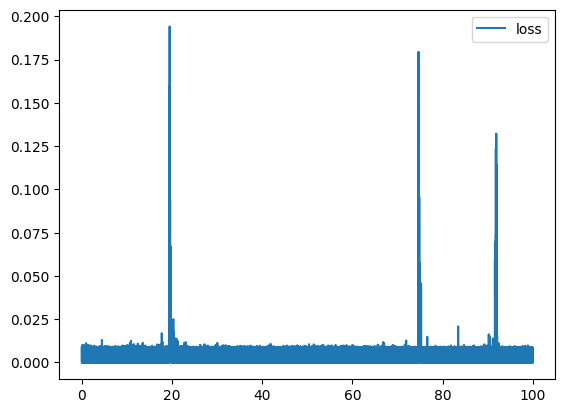

In [28]:
import matplotlib.pyplot as plt
plt.plot([x/(len(losses)/100) for x in range(len(losses))],losses, label="loss")
plt.legend(loc='best')
plt.show()

In [30]:
from sklearn.metrics import f1_score
f1_score(all_labels, all_preds, average='micro', labels=[i for i in range(4)])

0.60625